# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.0'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

iso_alpha_3
administrative_area_level
data_type
url
title
year
bibtype
author
institution
textVersion

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

iso_alpha_3
administrative_area_level
data_type
url
title
year
bibtype
author
institution
textVersion

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
191992,2020-08-26,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191993,2020-08-27,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191994,2020-08-28,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191995,2020-08-29,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191996,2020-08-30,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
191992,2020-08-26,Colombia,Vichada,14,2,0,12
191993,2020-08-27,Colombia,Vichada,14,2,0,12
191994,2020-08-28,Colombia,Vichada,14,2,0,12
191995,2020-08-29,Colombia,Vichada,14,2,0,12
191996,2020-08-30,Colombia,Vichada,14,2,0,12


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
160,2020-08-26,19846,3129,356,16361
161,2020-08-27,20096,3047,356,16693
162,2020-08-28,20322,2959,358,17005
163,2020-08-29,20569,2800,358,17411
164,2020-08-30,20717,2827,360,17530


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-08-26,24087089,7536773,826522,15723794,0.017157,0.326395,0.049940
2020-08-27,24359170,7605552,832270,15921348,0.017083,0.326804,0.049677
2020-08-28,24631775,7676304,837638,16117833,0.017003,0.327176,0.049402
2020-08-29,24887782,7717034,842633,16328115,0.016929,0.328035,0.049074
2020-08-30,24889786,7717678,842654,16329454,0.016928,0.328035,0.049071


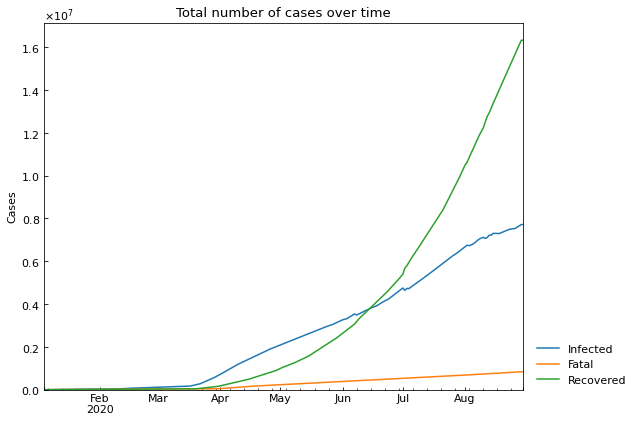

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
199,2020-08-26,64820,11918,1229,51673
200,2020-08-27,65682,11636,1240,52806
201,2020-08-28,66558,11322,1260,53976
202,2020-08-29,67401,10809,1271,55321
203,2020-08-30,68000,10571,1285,56144


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
197,2020-08-26,63822,10925,1209,51688
198,2020-08-27,64668,10619,1226,52823
199,2020-08-28,65573,10340,1238,53995
200,2020-08-29,66423,9827,1255,55341
201,2020-08-30,67264,9836,1264,56164


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
191992,2020-08-26,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191993,2020-08-27,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191994,2020-08-28,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191995,2020-08-29,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191996,2020-08-30,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
188328,COL,Colombia,Vichada,2020-08-26,107808
188329,COL,Colombia,Vichada,2020-08-27,107808
188330,COL,Colombia,Vichada,2020-08-28,107808
188331,COL,Colombia,Vichada,2020-08-29,107808
188332,COL,Colombia,Vichada,2020-08-30,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
191992,2020-08-26,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191993,2020-08-27,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191994,2020-08-28,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191995,2020-08-29,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
191996,2020-08-30,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
191992,2020-08-26,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
191993,2020-08-27,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
191994,2020-08-28,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
191995,2020-08-29,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
191996,2020-08-30,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
235,2020-08-26,1,1,1,0,0,1,1,3,2,2,1,30.56
236,2020-08-27,1,1,1,0,0,1,1,3,2,2,1,30.56
237,2020-08-28,1,1,1,0,0,1,1,3,2,2,1,30.56
238,2020-08-29,1,1,1,0,0,1,1,3,2,2,1,30.56
239,2020-08-30,1,1,1,0,0,1,1,3,2,2,1,30.56


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
235,2020-08-26,1,1,1,0,0,1,1,3,2,2,1,30.56
236,2020-08-27,1,1,1,0,0,1,1,3,2,2,1,30.56
237,2020-08-28,1,1,1,0,0,1,1,3,2,2,1,30.56
238,2020-08-29,1,1,1,0,0,1,1,3,2,2,1,30.56
239,2020-08-30,1,1,1,0,0,1,1,3,2,2,1,30.56


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

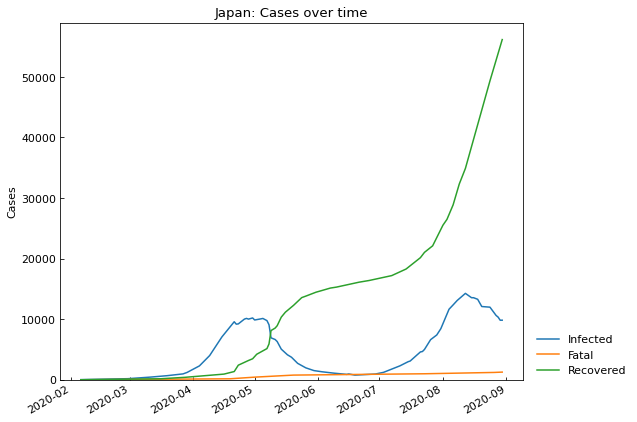

,Date,Confirmed,Infected,Fatal,Recovered
197,2020-08-26,63822,10925,1209,51688
198,2020-08-27,64668,10619,1226,52823
199,2020-08-28,65573,10340,1238,53995
200,2020-08-29,66423,9827,1255,55341
201,2020-08-30,67264,9836,1264,56164


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

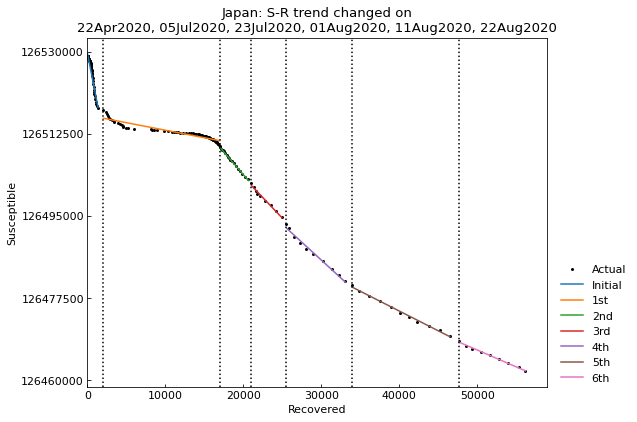

,Type,Start,End,Population
1st,Past,22Apr2020,04Jul2020,126529100
2nd,Past,05Jul2020,22Jul2020,126529100
3rd,Past,23Jul2020,31Jul2020,126529100
4th,Past,01Aug2020,10Aug2020,126529100
5th,Past,11Aug2020,21Aug2020,126529100
6th,Past,22Aug2020,30Aug2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	6th phase (22Aug2020 - 30Aug2020): finished  155 trials in 0 min  5 sec

	3rd phase (23Jul2020 - 31Jul2020): finished  482 trials in 0 min 10 sec

	2nd phase (05Jul2020 - 22Jul2020): finished 1908 trials in 1 min  0 sec

	4th phase (01Aug2020 - 10Aug2020): finished 1906 trials in 1 min  0 sec

	1st phase (22Apr2020 - 04Jul2020): finished 1832 trials in 1 min  0 sec

	5th phase (11Aug2020 - 21Aug2020): finished 1916 trials in 1 min  0 sec

Completed optimization. Total: 1 min 15 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
1st,Past,22Apr2020,04Jul2020,126529100,SIR-F,0.40,0.061665,0.000489,0.010303,0.023496,480,0.062,682,14,32,0.883772,1832,1 min 0 sec
2nd,Past,05Jul2020,22Jul2020,126529100,SIR-F,1.99,0.000489,0.000106,0.047411,0.023739,480,0.000,3152,14,7,0.030746,1908,1 min 0 sec
3rd,Past,23Jul2020,31Jul2020,126529100,SIR-F,1.89,0.000250,0.000076,0.046174,0.024298,480,0.000,4393,13,7,0.033084,482,0 min 10 sec
4th,Past,01Aug2020,10Aug2020,126529100,SIR-F,1.76,0.000011,0.000099,0.038092,0.021494,480,0.000,3368,15,8,0.033158,1906,1 min 0 sec
5th,Past,11Aug2020,21Aug2020,126529100,SIR-F,0.89,0.000288,0.000216,0.027070,0.030161,480,0.000,1543,11,12,0.020803,1916,1 min 0 sec
6th,Past,22Aug2020,30Aug2020,126529100,SIR-F,0.75,0.001284,0.000343,0.026885,0.035380,480,0.001,973,9,12,0.020583,155,0 min 5 sec


### Accuracy of estimation

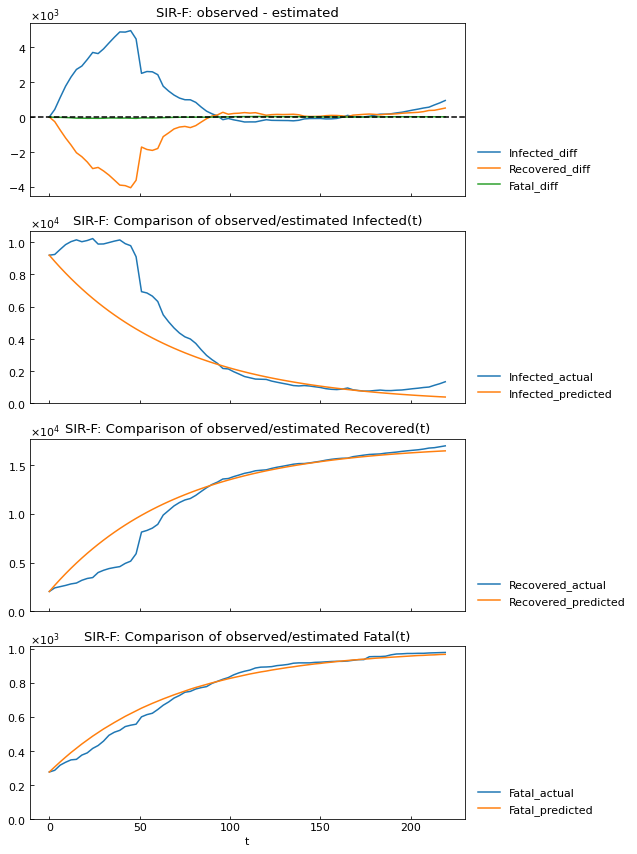

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.76

### Show parameter history

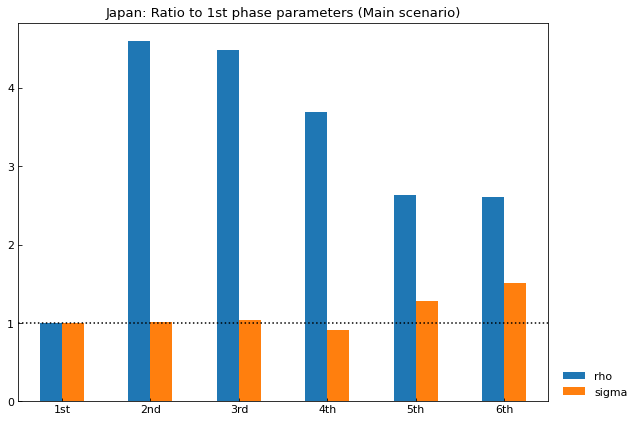

,1st,2nd,3rd,4th,5th,6th
rho,1.0,4.601835,4.481737,3.697234,2.627480,2.609539
sigma,1.0,1.010345,1.034138,0.914797,1.283683,1.505824


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

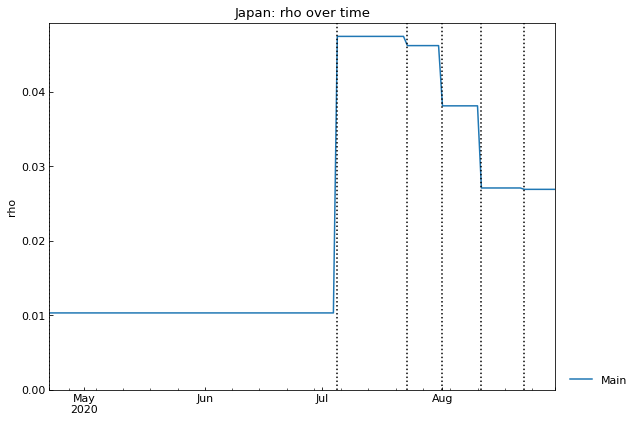

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

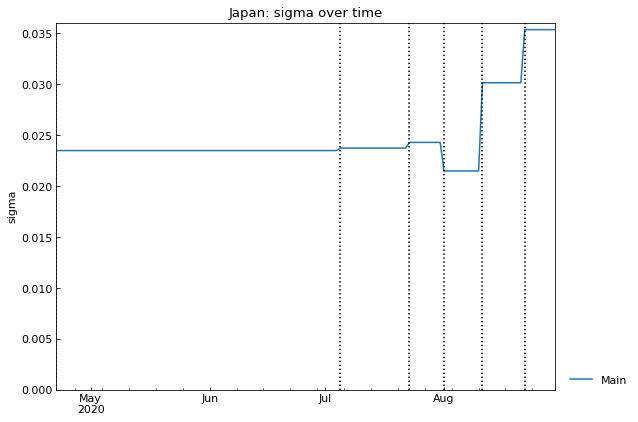

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

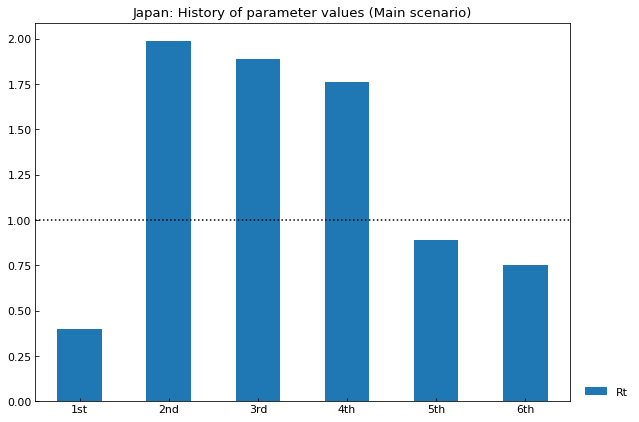

,1st,2nd,3rd,4th,5th,6th
Rt,0.4,1.99,1.89,1.76,0.89,0.75


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

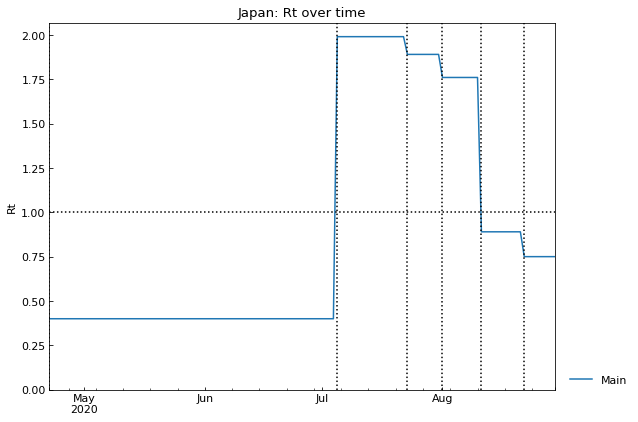

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

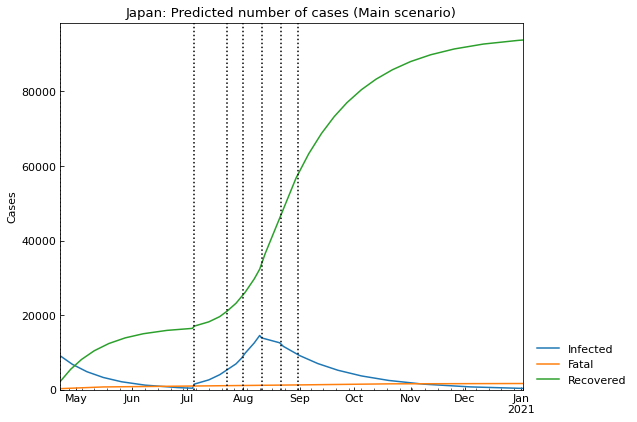

,Date,Confirmed,Fatal,Infected,Recovered
251,2020-12-29,95672,1659,384,93629
252,2020-12-30,95703,1660,374,93669
253,2020-12-31,95732,1660,364,93708
254,2021-01-01,95761,1660,355,93746
255,2021-01-02,95789,1661,345,93783


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.035380193242603816

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.07076038648520763

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     1st      Past  22Apr2020  04Jul2020   126529100  SIR-F  0.40   
         2nd      Past  05Jul2020  22Jul2020   126529100  SIR-F  1.99   
         3rd      Past  23Jul2020  31Jul2020   126529100  SIR-F  1.89   
         4th      Past  01Aug2020  10Aug2020   126529100  SIR-F  1.76   
         5th      Past  11Aug2020  21Aug2020   126529100  SIR-F  0.89   
         6th      Past  22Aug2020  30Aug2020   126529100  SIR-F  0.75   
         7th    Future  31Aug2020  01Jan2021   126529100  SIR-F  0.75   
Medicine 1st      Past  22Apr2020  04Jul2020   126529100  SIR-F  0.40   
         2nd      Past  05Jul2020  22Jul2020   126529100  SIR-F  1.99   
         3rd      Past  23Jul2020  31Jul2020   126529100  SIR-F  1.89   
         4th      Past  01Aug2020  10Aug2020   126529100  SIR-F  1.76   
         5th      Past  11Aug2020  21Aug2020   126529100  SIR-F  0.89   
         6th      Past  22Aug2020  30Aug2020   126529100  SIR-F  0.75   
         7th    Future  31Aug2020  30Sep2020   126529100  SIR-F  0.75   
         8th    Future  01Oct2020  01Jan2021   126529100  SIR-F  0.38   

                   theta     kappa       rho     sigma  tau  alpha1 [-]  \
Scenario Phase                                                            
Main     1st    0.061665  0.000489  0.010303  0.023496  480       0.062   
         2nd    0.000489  0.000106  0.047411  0.023739  480       0.000   
         3rd    0.000250  0.000076  0.046174  0.024298  480       0.000   
         4th    0.000011  0.000099  0.038092  0.021494  480       0.000   
         5th    0.000288  0.000216  0.027070  0.030161  480       0.000   
         6th    0.001284  0.000343  0.026885  0.035380  480       0.001   
         7th    0.001284  0.000343  0.026885  0.035380  480       0.001   
Medicine 1st    0.061665  0.000489  0.010303  0.023496  480       0.062   
         2nd    0.000489  0.000106  0.047411  0.023739  480       0.000   
         3rd    0.000250  0.000076  0.046174  0.024298  480       0.000   
         4th    0.000011  0.000099  0.038092  0.021494  480       0.000   
         5th    0.000288  0.000216  0.027070  0.030161  480       0.000   
         6th    0.001284  0.000343  0.026885  0.035380  480       0.001   
         7th    0.001284  0.000343  0.026885  0.035380  480       0.001   
         8th    0.001284  0.000343  0.026885  0.070760  480       0.001   

                1/alpha2 [day]  1/gamma [day]  1/beta [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     1st               682             14            32   0.883772   1832   
         2nd              3152             14             7  0.0307457   1908   
         3rd              4393             13             7  0.0330842    482   
         4th              3368             15             8   0.033158   1906   
         5th              1543             11            12  0.0208031   1916   
         6th               973              9            12  0.0205829    155   
         7th               973              9            12          -      -   
Medicine 1st               682             14            32   0.883772   1832   
         2nd              3152             14             7  0.0307457   1908   
         3rd              4393             13             7  0.0330842    482   
         4th              3368             15             8   0.033158   1906   
         5th              1543             11            12  0.0208031   1916   
         6th               973              9            12  0.0205829    155   
         7th               973              9            12          -      -   
         8th               973              4            12          -      -   

                     Runtime  
Scenario Phase                
Main     1st    1 min  0 sec  
         2nd    1 min  0 sec 

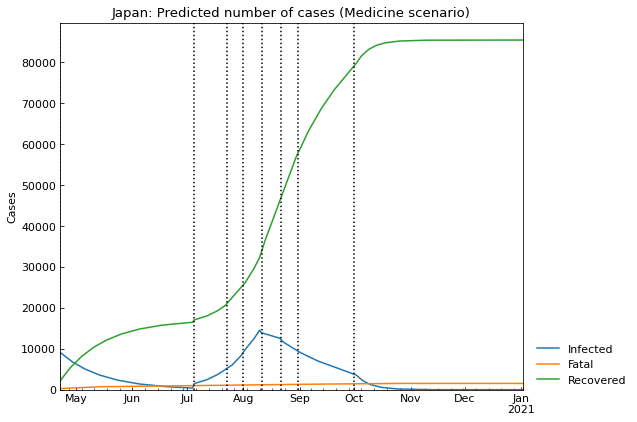

,Date,Confirmed,Fatal,Infected,Recovered
251,2020-12-29,86907,1536,0,85371
252,2020-12-30,86907,1536,0,85371
253,2020-12-31,86907,1536,0,85371
254,2021-01-01,86907,1536,0,85371
255,2021-01-02,86907,1536,0,85371


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,8th_Rt
Main,14544,10Aug2020,345,1661,-
Medicine,14544,10Aug2020,0,1536,0.38


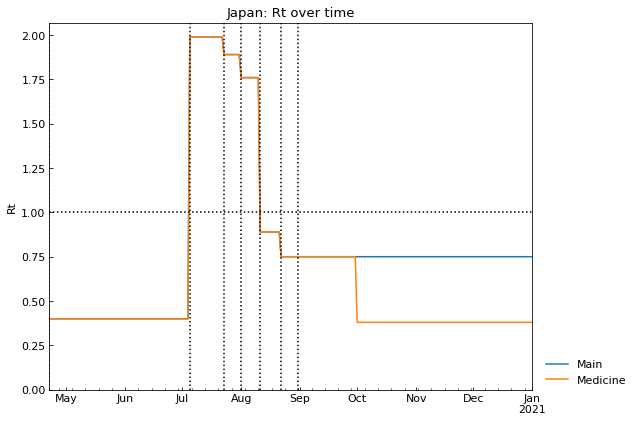

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

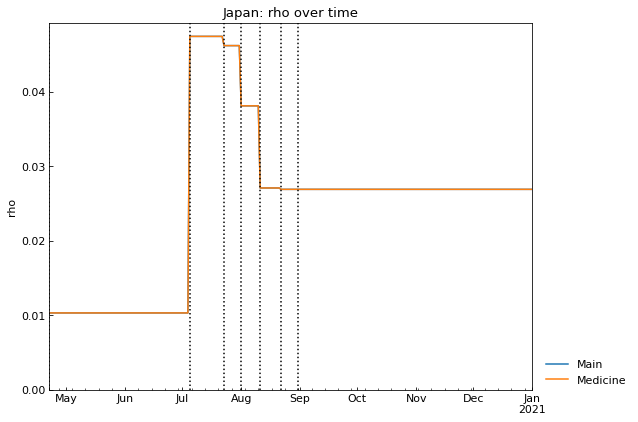

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

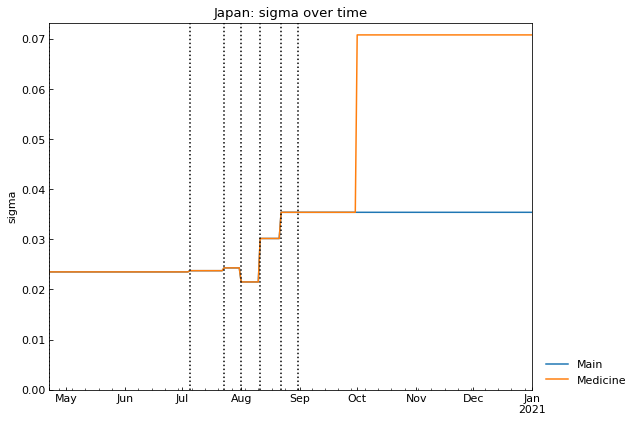

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

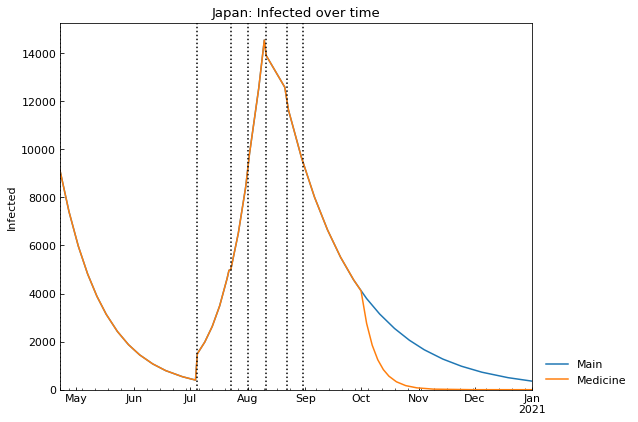

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")